In [1]:
# https://www.mdpi.com/2076-3417/12/19/10077

In [2]:
import geopandas as gpd
import rasterio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,\
                            precision_score,recall_score,f1_score,roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=UserWarning)
import joblib
import os
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

### Load sample points and sar data


In [ ]:
# sample_feature_path="output/sample_feature/eaton_sar_indices.csv"
# feature_column_names=["RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'Δvv_vh_ratio',"ΔRDFI","RCBI"]
# extended_file_name="_eaton_sar"

sample_feature_path="output/sample_feature/eaton_sar_optical_indices.csv"
feature_column_names=["dTRAD","dNBR","RBD_VV", "RBD_VH", "RBR_VV", "RBR_VH","ΔRVI",'Δvv_vh_ratio',"ΔRDFI","RCBI"]
extended_file_name="_eaton_sar_optical"

# Load SAR GeoTIFF
feature_image_path = "output/feature_image/eaton_sar_indices.tif"

training_data=pd.read_csv(sample_feature_path)

class_column_name='class'

output_model_dir="output/model/"
output_feat_imp_dir="output/feature_importance/"
corr_mat_dir="output/correlation/"



In [5]:
dataset = rasterio.open(feature_image_path)
# Get the number of bands
num_bands = dataset.count
print(f"Number of bands: {num_bands}")

Number of bands: 8


In [6]:
# Separate features (SAR bands) and labels (e.g., class column)
X = training_data[feature_column_names]  # Features (SAR band values)
Y = training_data[class_column_name]  # Labels (add 'Class' column in your CSV if available)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)


In [7]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Train-test split (assuming X_train and y_train are already defined)
# # X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# # Initialize the model
# gb_model = GradientBoostingClassifier(
#     n_estimators=1000,        # Allow a large number of trees initially
#     learning_rate=0.05,
#     max_depth=3,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     subsample=0.8,
#     random_state=42
# )

# # Initialize variables for early stopping
# best_score = -np.inf
# patience = 50  # Number of rounds to wait for improvement
# no_improvement_count = 0

# # Loop over the number of estimators
# for i in range(1, gb_model.n_estimators + 1):
#     # Fit the model up to the i-th iteration
#     gb_model.n_estimators = i
#     print((gb_model.n_estimators))
#     gb_model.fit(X_train, y_train)
    
#     # Calculate the validation score (e.g., accuracy)
#     val_score = gb_model.score(X_test, y_test)
#     print(val_score)
#     # Check if the validation score has improved
#     if val_score > best_score:
#         best_score = val_score
#         no_improvement_count = 0  # Reset the counter
#     else:
#         no_improvement_count += 1
    
#     # If no improvement for 'patience' rounds, stop training
#     if no_improvement_count >= patience:
#         print(f"Early stopping at iteration {i}")
#         break

# # Final model after early stopping
# print(f"Best validation score: {best_score}")


In [8]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Assuming X_train_full and y_train_full are already defined
# # Train-test split
# # X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# # Initialize the Random Forest model with a large number of trees
# rf_model = RandomForestClassifier(
#     n_estimators=1000,  # Allow a large number of trees initially
#     max_depth=10,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     random_state=42
# )

# # Initialize variables for early stopping
# best_score = -np.inf
# patience = 50  # Number of rounds to wait for improvement
# no_improvement_count = 0

# # Loop over the number of estimators (trees)
# for i in range(1, rf_model.n_estimators + 1):
#     # Incrementally fit the Random Forest model with the i-th number of trees
#     rf_model.set_params(n_estimators=i)
#     rf_model.fit(X_train, y_train)
    
#     # Calculate the validation score (e.g., accuracy)
#     val_score = rf_model.score(X_test, y_test)
#     print(f"Iteration {i}, Validation Score: {val_score}")
    
#     # Check if the validation score has improved
#     if val_score > best_score:
#         best_score = val_score
#         no_improvement_count = 0  # Reset the counter
#     else:
#         no_improvement_count += 1
    
#     # If no improvement for 'patience' rounds, stop training
#     if no_improvement_count >= patience:
#         print(f"Early stopping at iteration {i}")
#         break

# # Final model after early stopping
# print(f"Best validation score: {best_score}")


In [9]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Define base learners (models to be stacked)
# base_learners = [
#     ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
#     ('svm', SVC(probability=True, random_state=42))
# ]

# # Meta-model (Logistic Regression)
# meta_model = LogisticRegression()

# # Create the Stacking Classifier
# stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

# # Train the Stacking model
# stacking_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_stack = stacking_model.predict(X_test)

# # Evaluate the Stacking model's performance
# accuracy_stack = accuracy_score(y_test, y_pred_stack)
# print(f"Accuracy of Stacking model: {accuracy_stack:.2f}")


In [10]:
#indices_tex
# RF_Model_1=RandomForestClassifier(n_estimators= 150, min_samples_split= 8, max_features= 9, max_depth= 10)

#gamma_indices
# RF_Model_1=RandomForestClassifier(n_estimators= 100, min_samples_split= 8, max_features= 20, max_depth= 8)

#gamma
# RF_Model_0=RandomForestClassifier(n_estimators= 150, min_samples_split= 15, max_features= 20, max_depth= 12)
# RF_Model_1=RandomForestClassifier(n_estimators= 200, min_samples_split= 8, max_features= 20, max_depth= 8)
# {'n_estimators': 150, 'min_samples_split': 20, 'max_features': 4, 'max_depth': 15}
#indices
# RF_Model_0=RandomForestClassifier(n_estimators= 150, min_samples_split= 4, max_features= 20, max_depth= 10)
# RF_Model_1=RandomForestClassifier(n_estimators= 150, min_samples_split= 8, max_features= 7, max_depth= 8)


#eaton indices
# RF_Model_0=RandomForestClassifier(n_estimators= 200,random_state=42)
# max_depth= 8
# {'n_estimators': 100, 'min_samples_split': 40, 'max_features': 3, 'max_depth': 8}
RF_Model=RandomForestClassifier(n_estimators= 100, min_samples_split= 40, max_features= 3,max_depth= 8,bootstrap=True)
# RF_Model_1=RandomForestClassifier(n_estimators= 100, min_samples_split= 4, max_features= 8, max_depth= 5)
# RF_Model_0 = RandomForestClassifier(
#     n_estimators=100,               # Number of trees in the forest
#     max_depth=None,                  # Trees can grow deep to capture complex patterns
#     min_samples_split=2,             # Minimum samples required to split an internal node
#     min_samples_leaf=1,              # Minimum samples required to be at a leaf node
#     max_features='sqrt',             # Use square root of the total features for each split
#     bootstrap=True,                  # Use bootstrap sampling (default)
#     n_jobs=-1,                       # Use all available processors
#     random_state=42                  # Ensures reproducibility
# )

# SVM_Model = svm.SVC()
SVM_Model= LinearSVC(random_state=42, tol=1e-3)

***************RandomForest0*********************
Model performance for Training set
- Accuracy: 0.9792746113989638
- F1 Score: 0.9792778787373403
- Precision Score: 0.9645583424209379
- Recall Score: 0.9656113537117904
- Roc Auc Score: 0.9753240930621568
--------------
Model performance for Test set
- Accuracy: 0.9740932642487047
- F1 Score: 0.9740482164921273
- Precision Score: 0.9641350210970464
- Recall Score: 0.9520833333333333
- Roc Auc Score: 0.9680529448621554
----------------------------------------
Model saved successfully!
Index(['id', 'Dnbr1', 'dTRAD1', 'class', 'geometry', 'dTRAD', 'dNBR', 'RBD_VV',
       'RBD_VH', 'RBR_VV', 'RBR_VH', 'ΔRVI', 'Δvv_vh_ratio', 'ΔRDFI', 'RCBI'],
      dtype='object')
Index(['dTRAD', 'dNBR', 'RBD_VV', 'RBD_VH', 'RBR_VV', 'RBR_VH', 'ΔRVI',
       'Δvv_vh_ratio', 'ΔRDFI', 'RCBI'],
      dtype='object')


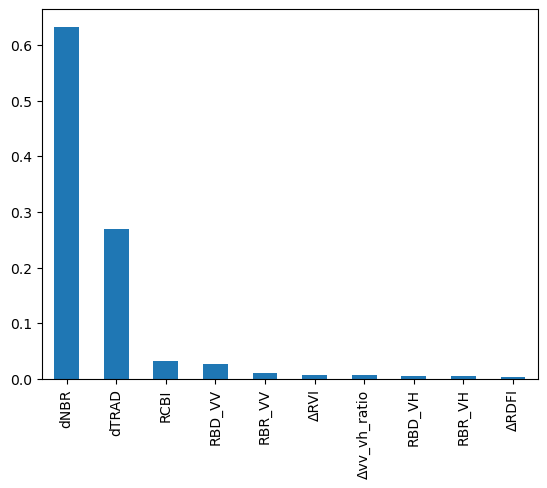

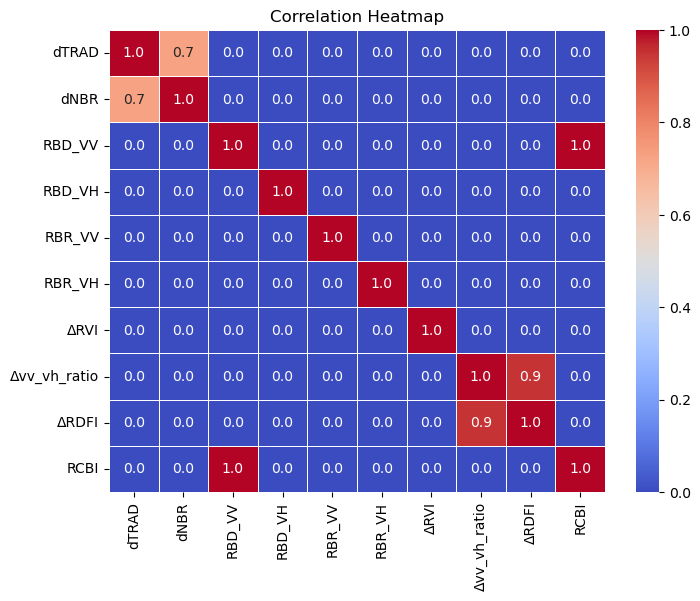

In [11]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

models={
    "RandomForest0": RF_Model,
    # "SVM_Model": SVM_Model
    # "RandomForest1": RF_Model_1,
    # "RandomForest2": RF_Model_2,
    # "RandomForest3": RF_Model_3,
    # "RandomForest4": RF_Model_4,
    # "RandomForest5": RF_Model_5,

    # "Decision Tree":DecisionTreeClassifier(),
    # "Logistic Regression":LogisticRegression()
    # "XGBoost": XGB_Model
}


for i in range(len(list(models))):
    model_name=list(models.keys())[i]
    print(f"***************{model_name}*********************")
    model=list(models.values())[i]

    # scaler = StandardScaler()
    # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels
    # X_train=scaler.fit_transform(X_train)
    model.fit(X_train, y_train)
    # print("score",model.score(X_test,y_test))

    #Make a prediction
    y_train_pred=model.predict(X_train)
    # y_test_pred=model.predict(scaler.transform(X_test))
    y_test_pred=model.predict(X_test)


    #Training set performance
    model_train_accuracy=accuracy_score(y_train,y_train_pred)
    model_train_f1=f1_score(y_train,y_train_pred,average='weighted')
    model_train_precision=precision_score(y_train,y_train_pred)
    model_train_recall=recall_score(y_train,y_train_pred)
    model_train_roc_auc_score=roc_auc_score(y_train,y_train_pred)

    #Test set performance
    model_test_accuracy=accuracy_score(y_test,y_test_pred)
    model_test_f1=f1_score(y_test,y_test_pred,average='weighted')
    model_test_precision=precision_score(y_test,y_test_pred)
    model_test_recall=recall_score(y_test,y_test_pred)
    model_test_roc_auc_score=roc_auc_score(y_test,y_test_pred)

    # print(model)
    print('Model performance for Training set')
    print(f"- Accuracy: {model_train_accuracy}")
    print(f"- F1 Score: {model_train_f1}")
    print(f"- Precision Score: {model_train_precision}")
    print(f"- Recall Score: {model_train_recall}")
    print(f"- Roc Auc Score: {model_train_roc_auc_score}")

    print("--------------")
    print('Model performance for Test set')
    print(f"- Accuracy: {model_test_accuracy}")
    print(f"- F1 Score: {model_test_f1}")
    print(f"- Precision Score: {model_test_precision}")
    print(f"- Recall Score: {model_test_recall}")
    print(f"- Roc Auc Score: {model_test_roc_auc_score}")
    print("----------------------------------------")

    
    # Assuming you have a trained model called `model`
    joblib.dump(model, f'{output_model_dir}{model_name}{extended_file_name}.pkl')
    print("Model saved successfully!")

     # Plot a simple bar chart
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_importances.plot.bar()
    plt.savefig(f"{output_feat_imp_dir}{model_name}{extended_file_name}.png", dpi=300, bbox_inches="tight")  # Change filename & format as needed

    print(training_data.columns)
    #export correlation matrix
    training_data_1 = training_data.drop(columns=['id','class','geometry','Dnbr1','dTRAD1'])
    print(training_data_1.columns)

    correlation_matrix = training_data_1.corr(method='pearson').round(2)
    correlation_matrix = correlation_matrix.applymap(lambda x: x if x >= 0.7 else 0)
    correlation_matrix.to_csv(f"{corr_mat_dir}{model_name}{extended_file_name}.csv", index=True)
    plt.savefig(f"{corr_mat_dir}{model_name}{extended_file_name}.png", dpi=300, bbox_inches="tight")  # PNG format

    # Create heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

    # predict(model, feature_image_path,model_name,scaler)
    # predict(model, feature_image_path,model_name)

    # predict(model, "output/sar_image/palisades_sar_indices.tif",model_name)




## plot AUC curve

In [13]:
# ## plot ROC AUC Curve
# plt.figure()
# auc_models = [{
#     'label': 'Random Forest Classifier',
#     'model': RF_Model,
#     'auc':0.73
# }]

# for algo in auc_models:
#     model=algo['model']
#     model.fit(X_train, y_train)
#     fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
#     plt.plot(fpr,tpr,label="Random Forest Classifier ROC (area= 0.71)")

#     plt.plot([0,1],[0,1],'r--')
#     plt.xlim([0.0,1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('1-Specificity (False Positive Rate)')
#     plt.ylabel('Sensitivity (True Positive Rate)')
#     plt.title('Receiver operating characteristics')

#     plt.legend(loc="lower right")

#     plt.savefig("auc.png")
#     plt.show()

#     # Open the TIFF file using rasterio
#     # output_path = "palisades_predictions.tif"  # Replace with your TIFF file path
    
